# New Revisions

- Confirm the behavior (shrinking core, expanding outer) for a sweep of parameters ✅.
- There is some problem with the binning of the GFDL models (seems to happen in the preprocessing nb)


In [1]:
# !mamba install tqdm -y

In [2]:
# !mamba update xarray -y

In [3]:
from xarrayutils.utils import sign_agreement

import cf_xarray
from xarrayutils.plotting import shaded_line_plot
from xarrayutils.utils import linear_trend
from busecke_etal_2021_aguadv.plotting import model_color_legend, o2_model_colors

from xarrayutils.plotting import linear_piecewise_scale

import xarray as xr
import numpy as np
import pathlib
import warnings
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

# from tqdm.auto import tqdm
# from tqdm.notebook import tqdm
from fastprogress import progress_bar

from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.drift_removal import replace_time

from cmip6_omz.utils import o2_models
from cmip6_omz.units import convert_mol_m3_mymol_kg

from dask.diagnostics import ProgressBar

from xarrayutils.utils import linear_trend
from dask.diagnostics import ProgressBar

from busecke_etal_2021_aguadv.plotting import model_color_legend, o2_model_colors

from cmip6_omz.upstream_stash import zarr_exists

%matplotlib inline

In [63]:
from xarrayutils.plotting import shaded_line_plot

In [4]:
# # set up dask
# from dask.distributed import LocalCluster, Client
# mem_total = 256
# workers = 3
# threads = 5 # 4*6 seemed to work quite well, but I would like this to perform a bit better
# cluster = LocalCluster(
#     memory_limit=f"{int(mem_total/workers)}GiB",
#     dashboard_address=9999,
#     threads_per_worker=threads,
#     n_workers = workers,
#                       )
# client = Client(cluster)
# client

In [5]:
# set up dask
from dask.distributed import LocalCluster, Client
mem_total = 200
workers = 6
threads = 6 # 4*6 seemed to work quite well, but I would like this to perform a bit better
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 6
Total threads: 36,Total memory: 198.00 GiB
Comm: tcp://127.0.0.1:35780,Workers: 6
Dashboard: http://127.0.0.1:9999/status,Total threads: 36
Started: Just now,Total memory: 198.00 GiB
Comm: tcp://127.0.0.1:43456,Total threads: 6
Dashboard: http://127.0.0.1:41695/status,Memory: 33.00 GiB
Nanny: tcp://127.0.0.1:43230,


In [5]:
def slope(da):
    return linear_trend(da.sel(time=trend_slice), 'time').slope * 100

In [6]:
def depth_binning(ds, depth_bins=[500, 1000, 2000, 4000, 8000]):
    # create depth slices
    slices = [slice(0, depth_bins[i]) for i in range(len(depth_bins))]
    datasets = []
    for sl in slices:
        bounds = np.array([sl.start, sl.stop])
        lev = bounds.sum() / 2
        ds_slice = (
            ds.sel(lev=sl)
            .sum("lev")
            .assign_coords(lev=lev, lev_bounds=xr.DataArray(bounds, dims="bnds"))
        )

        datasets.append(ds_slice)
    out = xr.concat(datasets, "lev")
    out.attrs = ds.attrs
    return out


def rebin_o2(ds):
    ## Reshape o2 bins
    #     new_bins = [-10, 20, 40, 60, 80, 100, 120, 140]
    #     new_bins = [-10, 15, 30, 45, 60, 75, 90, 105, 120, 135]
#     new_bins = [-10, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
    new_bins = [-1e12, 5, 10, 20, 50, 100, 150, 2000] 
    # important to have the left edge really low to get the near 0 values

    ds = ds.groupby_bins(
        ds.o2_bin, new_bins, labels=new_bins[1:], #maybe label the middle?
        right=False,
    ).sum(['o2_bin'])
    ds = ds.rename({'o2_bin_bins':'o2_bin'})
    return ds




#     ## this was not what I expected. Lets do it the painful manual way
#     new_bins = [-10000, 5, 20, 50, 100, 150]
#     bin_datasets = []
#     for bi in range(len(new_bins) - 1):
#         bin_o2 = np.array([new_bins[bi], new_bins[bi + 1]])
#         print(bin_o2)
#         ds_bin = ds.sel(o2_bin=slice(bin_o2[0], bin_o2[1]))
#         print(ds_bin)
#         ds_bin_summed = ds_bin.sum(["o2_bin"])
#         ds_bin_summed = ds_bin_summed.assign_coords(o2_bin=bin_o2.mean())
#         ds_bin_summed = ds_bin_summed.assign_coords(
#             o2_bin_bounds=xr.DataArray(
#                 [ds_bin.o2_bin_bounds.min().data, ds_bin.o2_bin_bounds.max().data],
#                 dims=["bnds"],
#             )
#         )
#         bin_datasets.append(ds_bin_summed)
#     ds_rebinned = xr.concat(bin_datasets, 'o2_bin')
#     return ds_rebinned

In [7]:
def preprocess(ds):
    #     ds_out = ds
    ds_out = ds.drop_vars(
        [vv for vv in ds.data_vars if vv not in ["volume", "bin_count", "agessc"]]  # ,
    )
    #     if 'agessc' in ds_out.data_vars and ds.source_id in fail_age_models:
    #         ds_out = ds_out.drop_vars('agessc')

    #     if not 'agessc' in ds_out.data_vars:
    #         ds_out['agessc'] = xr.ones_like(ds_out.volume) * np.nan

    ds_out = ds_out.sel(
        basin_mask_bin=["North Pacific Ocean", "South Pacific Ocean"]
    ).sum(["basin_mask_bin"], keep_attrs=True)

    # fix attrs for obs
    if "variant_label" not in ds_out.attrs:
        ds_out.attrs = {
            "source_id": "Obs_Bianchi",
            "grid_label": "none",
            "table_id": "none",
            "variant_label": "none",
        }
    attrs = ds_out.attrs

    # make sure that the long members are not included here
    if "time" in ds.dims:
        ds_out = ds_out.sel(time=slice(None, "2100"))

    # adjust the o2_bins early
    ds_out = rebin_o2(ds_out)
    ds_out.attrs = attrs
    return ds_out

## Start

In [8]:
fail_age_models = ['MRI-ESM2-0','MPI-ESM1-2-HR','MPI-ESM1-2-LR',]
hist_slice = slice('1850', '1900')
trend_slice = slice('2000', '2100')
ifolder = pathlib.Path("../../data/interim/Revisions_2.0/")
ofolder = pathlib.Path("/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.1/")
ofolder_patch = pathlib.Path("/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.2/")

In [9]:
kwargs = {"use_cftime": True, "consolidated": True}
# little hacky untils all members are in the v2.2 folder
flist = list(ofolder.glob("*.zarr"))
datasets = [xr.open_zarr(f, **kwargs) for f in flist]

In [51]:
# patch in the newer GFDL datasets (this can be removed once all data is reprocessed)
# remove the GFDL ones from the old
datasets = [ds for ds in datasets if 'GFDL' not in ds.attrs.get('source_id', 'none')]

#
flist_patch = list(ofolder_patch.glob("*GFDL*.zarr"))
datasets_patch = [xr.open_zarr(f, **kwargs) for f in flist_patch]

flist_comparison = list(ofolder.glob("*GFDL*.zarr"))
datasets_comparison = [xr.open_zarr(f, **kwargs) for f in flist_comparison]

## correct a bug in the processing (I took the sum in time and not the mean)
warnings.warn('REMOVE THIS WHEN USING THE NEWER VERSION (>=2.3)')
def _patch(ds):
    attrs = ds.attrs
    if len(ds.time)>300:
        raise RuntimeError('This is a monthly dataset?')
    ds = ds/12 # accidentally saved yearly sum, not mean
    ds.attrs = attrs
    return ds
datasets_patch = [_patch(ds) for ds in datasets_patch]
datasets.extend(datasets_patch)

/tmp/ipykernel_51579/1710463063.py:13: UserWarning: REMOVE THIS WHEN USING THE NEWER VERSION (>=2.3)
  warnings.warn('REMOVE THIS WHEN USING THE NEWER VERSION (>=2.3)')


# Load preprocessed data

Optionally delete and recreate with:
```python
# import shutil
# shutil.rmtree(ifolder)
```

In [53]:
# import shutil
# for f in ifolder.glob('*GFDL*.zarr'):
#     print(f)
#     shutil.rmtree(f)

In [54]:
def check_consistency(ds):
    consistency_check = True
    if "time" in ds.dims:
        # run some rudimentary checks:

        # the total number of bins should not change
        global_bins = ds.bin_count.sum(
            ["lat_bin", "basin_mask_bin", "o2_bin", "lev"]
        ).load()
        negative_bins = (
            ds.bin_count.isel(o2_bin=0)
            .sum(["lat_bin", "basin_mask_bin", "lev"])
            .load()
        )
        if not (abs((global_bins - global_bins.isel(time=0).data)) < 2).all():
            print("---------------------------------------------\n" + name)
            print(f"FAILED: Global bin count not preserved")
            plt.figure()
            plt.plot(global_bins)
            plt.title(name)
            plt.show()
            if not 'CM4' in name: # CM4 does not show a drop in bins but rather a really slight decline in bins? Is this due to regridding?
                consistency_check = False

        # there should not be many negative values
        max_negative_perc = (negative_bins / global_bins * 100).max()
        if not max_negative_perc < 3:  # this is kind of a lot...:
            print("---------------------------------------------\n" + name)
            print(f"FAILED: Percentage of cells with negative oxygen: {max_negative_perc.data}")
            consistency_check = False
    return consistency_check
    

ddict = {}
overwrite = False
for ds in progress_bar(datasets):
    name = cmip6_dataset_id(ds)
    print("---------------------------------------------\n" + name)
    filename = ifolder.joinpath(name + ".zarr")
    

#     check = check_consistency(ds)
    #dont do for now...Shouldnt this be done afterwards?
    
    check = True
    
    if not zarr_exists(filename) or overwrite:
        ds = ds.chunk({k: v for k, v in {"time": -1, "o2_bin": -1}.items() if k in ds.dims})
        ds = preprocess(ds)
        print(f"Writing to {filename}")
        ds.to_zarr(filename, consolidated=True, mode="w")
                
    print(f'reloading {name}')
    ds_reloaded = xr.open_zarr(
        filename, use_cftime=True, consolidated=True
    )
    print(f"variables: {ds_reloaded.data_vars}")
    ddict[cmip6_dataset_id(ds)] = ds_reloaded

---------------------------------------------
none.CCCma.CanESM5.none.r5i1p1f1.Omon.gn.v20190429.none
reloading none.CCCma.CanESM5.none.r5i1p1f1.Omon.gn.v20190429.none
variables: Data variables:
    agessc     (o2_bin, time, lev, lat_bin) float64 dask.array<chunksize=(1, 3012, 45, 12), meta=np.ndarray>
    bin_count  (o2_bin, time, lev, lat_bin) float64 dask.array<chunksize=(1, 3012, 45, 12), meta=np.ndarray>
    volume     (o2_bin, time, lev, lat_bin) float32 dask.array<chunksize=(1, 3012, 45, 12), meta=np.ndarray>
---------------------------------------------
none.MOHC.UKESM1-0-LL.none.r1i1p1f2.Omon.gn.none.none
reloading none.MOHC.UKESM1-0-LL.none.r1i1p1f2.Omon.gn.none.none
variables: Data variables:
    bin_count  (o2_bin, time, lev, lat_bin) float64 dask.array<chunksize=(1, 3012, 75, 12), meta=np.ndarray>
    volume     (o2_bin, time, lev, lat_bin) float32 dask.array<chunksize=(1, 3012, 75, 12), meta=np.ndarray>
---------------------------------------------
none.MIROC.MIROC-ES2L.n

In [57]:
# ds = ddict['none.NOAA-GFDL.GFDL-ESM4.none.r1i1p1f1.Omon.gn.none.none']
# mask = ds.volume.sum([di for di in ds.volume.dims if di!='time'])
# mask.plot()

In [58]:
list(ddict.keys())

['none.CCCma.CanESM5.none.r5i1p1f1.Omon.gn.v20190429.none',
 'none.MOHC.UKESM1-0-LL.none.r1i1p1f2.Omon.gn.none.none',
 'none.MIROC.MIROC-ES2L.none.r8i1p1f2.Omon.gn.none.none',
 'none.none.none.none.none.none.none.none.none',
 'none.IPSL.IPSL-CM6A-LR.none.r6i1p1f1.Omon.gn.none.none',
 'none.MIROC.MIROC-ES2L.none.r1i1p1f2.Omon.gn.none.none',
 'none.MPI-M.MPI-ESM1-2-LR.none.r3i1p1f1.Omon.gn.none.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r3i1p1f1.Omon.gn.v20191203.none',
 'none.MIROC.MIROC-ES2L.none.r6i1p1f2.Omon.gn.none.none',
 'none.IPSL.IPSL-CM6A-LR.none.r14i1p1f1.Omon.gn.none.none',
 'none.MIROC.MIROC-ES2L.none.r2i1p1f2.Omon.gn.none.none',
 'none.CCCma.CanESM5.none.r6i1p2f1.Omon.gn.v20190429.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r4i1p1f1.Omon.gn.none.none',
 'none.CCCma.CanESM5.none.r2i1p2f1.Omon.gn.v20190429.none',
 'none.MPI-M.MPI-ESM1-2-LR.none.r6i1p1f1.Omon.gn.none.none',
 'none.CSIRO.ACCESS-ESM1-5.none.r2i1p1f1.Omon.gn.none.none',
 'none.CNRM-CERFACS.CNRM-ESM2-1.none.r2i1p1f2.Omon.g

In [59]:
# some CanESM runs have no age, but other do? TODO: Invesigate a sleeker way to get this done in xarray?
ddict_filtered = {k:ds for k,ds in ddict.items() if not ('CanESM' in ds.source_id and 'agessc' not in ds.data_vars)}

In [60]:
# combine members
from cmip6_preprocessing.postprocessing import concat_members
ddict_combined = concat_members(ddict_filtered, concat_kwargs={'combine_attrs': 'drop_conflicts', 'join':'override', 'compat':'override', 'coords':'minimal'})

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [61]:
sorted(list(ddict_combined.keys()))

['ACCESS-ESM1-5.gn.Omon',
 'CNRM-ESM2-1.gn.Omon',
 'CanESM5-CanOE.gn.Omon',
 'CanESM5.gn.Omon',
 'GFDL-CM4.gn.Omon',
 'GFDL-ESM4.gn.Omon',
 'IPSL-CM6A-LR.gn.Omon',
 'MIROC-ES2L.gn.Omon',
 'MPI-ESM1-2-HR.gn.Omon',
 'MPI-ESM1-2-LR.gn.Omon',
 'MRI-ESM2-0.gn.Omon',
 'NorESM2-LM.gr.Omon',
 'NorESM2-MM.gr.Omon',
 'Obs_Bianchi.none.none',
 'UKESM1-0-LL.gn.Omon']

## Visualize the change in volume per depth

In [62]:
from xarrayutils.filtering import filter_1D

In [29]:
def rebin_lev(ds):
    ds = ds.reset_coords('dz')
#     new_bins = np.array([0, 2000, 4000, 8000])
    new_bins = np.arange(0, 8000, 500)
    ds = ds.groupby_bins(
        ds.lev, new_bins, labels=(new_bins[1:]+new_bins[:-1])/2, #maybe label the middle?
        right=False,
    ).sum(['lev'])
#     ds = ds.rename({'o2_bin_bins':'o2_bin'})
    return ds

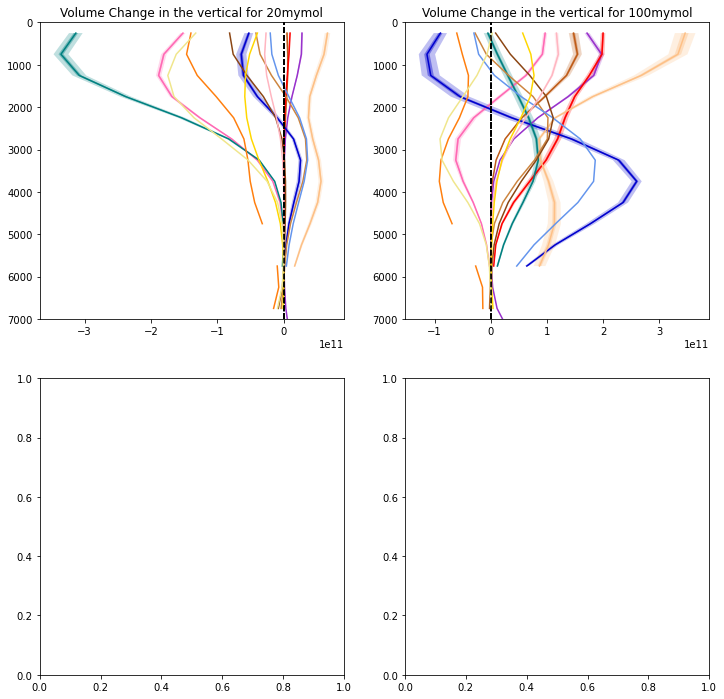

In [30]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[12,12])
    for th, ax in zip([20, 100],axarr.flat):
        ax.set_title(f"Volume Change in the vertical for {th}mymol")
        for name, ds in ddict_combined.items():
            if "Bianchi" not in name:
                ds_raw = ds.copy()
                dz = (
                    cf_xarray.bounds_to_vertices(ds.lev_bounds, "bnds")
                    .diff("lev_vertices")
                    .rename({"lev_vertices": "lev"})
                )

                ds['dz']=dz
                ds = ds.sel(lat_bin=slice(-30, 30), o2_bin=slice(-200, th)).sum(
                    ["o2_bin", "lat_bin"]
                )
                ds_coarse = rebin_lev(ds)

                def _prep(ds):
                    da = ds.volume
                    da = da / ds.dz
                    da = slope(da.sel(time=trend_slice)).load()
                    return da

                da = _prep(ds)        
                da_coarse = _prep(ds_coarse)        

                # Can I just filter this? That is sketchy...
                da_coarse = filter_1D(da_coarse, 2, dim='lev_bins') 

                shaded_line_plot(
                    da_coarse,
                    "member_id",
                    horizontal=False,
                    ax = ax,
                    line_kwargs={"color": o2_model_colors()[ds_raw.source_id]},
                )
            ax.set_ylim(7000, 0)
            ax.axvline(0, color='k', ls='--')

## Steps
- Combine Members and add sign_agreement variabel for all variables
- Rebin in uneven bins that represent some meaningful regimes [0,10, 20, 50, 100] (maybe for later)

## Prototype age scatter
- GFDL is not properly binned (checking upstream)

In [100]:
ddict_combined['UKESM1-0-LL.gn.Omon']

<xarray.Dataset>
Dimensions:     (member_id: 5, o2_bin: 6, time: 3012, lev: 75, lat_bin: 12, bnds: 2)
Coordinates:
  * lat_bin     (lat_bin) float64 -55.0 -45.0 -35.0 -25.0 ... 35.0 45.0 55.0
    lat_bounds  (bnds, lat_bin) int64 dask.array<chunksize=(2, 12), meta=np.ndarray>
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * o2_bin      (o2_bin) int64 5 10 20 50 100 150
  * time        (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * member_id   (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' ... 'r3i1p1f2' 'r4i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    bin_count   (member_id, o2_bin, time, lev, lat_bin) float64 dask.array<chunksize=(1, 1, 3012, 75, 12), meta=np.ndarray>
    volume      (member_id, o2_bin, time, lev, lat_bin) float32 dask.array<chunksize=(1, 1, 3012, 75, 12), meta=np.ndarray>
Attributes: (12/32)
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         standard
    cmor_version:          3.4.0
    cv_version:            6.2.20.1
    data_specs_version:    01.00.29
    external_variables:    areacello volcello
    ...                    ...
    sub_experiment:        none
    sub_experiment_id:     none
    table_id:              Omon
    table_info:            Creation Date:(13 December 2018) MD5:2b12b5db6db11...
    title:                 UKESM1-0-LL output prepared for CMIP6
    variable_name:         o2

CanESM5.gn.Omon
UKESM1-0-LL.gn.Omon
MIROC-ES2L.gn.Omon
Obs_Bianchi.none.none
IPSL-CM6A-LR.gn.Omon
MPI-ESM1-2-LR.gn.Omon
ACCESS-ESM1-5.gn.Omon
CNRM-ESM2-1.gn.Omon
NorESM2-MM.gr.Omon
MPI-ESM1-2-HR.gn.Omon
NorESM2-LM.gr.Omon
CanESM5-CanOE.gn.Omon
MRI-ESM2-0.gn.Omon
GFDL-ESM4.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GFDL-CM4.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CanESM5.gn.Omon
UKESM1-0-LL.gn.Omon
MIROC-ES2L.gn.Omon
Obs_Bianchi.none.none
IPSL-CM6A-LR.gn.Omon
MPI-ESM1-2-LR.gn.Omon
ACCESS-ESM1-5.gn.Omon
CNRM-ESM2-1.gn.Omon
NorESM2-MM.gr.Omon
MPI-ESM1-2-HR.gn.Omon
NorESM2-LM.gr.Omon
CanESM5-CanOE.gn.Omon
MRI-ESM2-0.gn.Omon
GFDL-ESM4.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GFDL-CM4.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/core.py

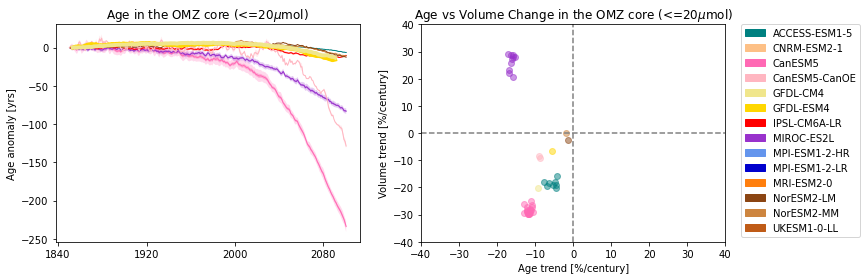

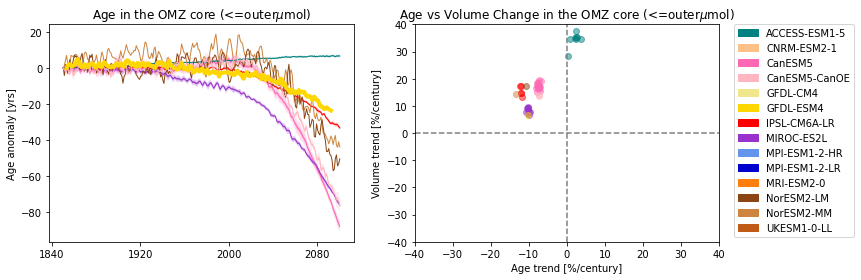

In [99]:
# lets look at the core first
for th in [20, "outer"]:
    fig, axarr = plt.subplots(ncols=2, figsize=[12, 4])
    ts_ax = axarr[0]
    scatter_ax = axarr[1]

    for k, ds in ddict_combined.items():
        print(k)
        if "agessc" in ds.data_vars and ds.source_id not in fail_age_models:
            if th == "outer":
                ds_p = ds.sel(
                    lat_bin=slice(-30, 30), lev=slice(0, 1000), o2_bin=slice(90, None)
                )
            else:
                ds_p = ds.sel(lat_bin=slice(-30, 30), o2_bin=slice(-5, th))

            ds_p = ds_p.sum(["lat_bin", "lev", "o2_bin"])

            # mask out missing age in GFDL
            lw = 1
            if "GFDL" in k:
                lw = 4
                mask = ds_p.agessc < ds_p.agessc.quantile(0.05, "time")
                ds_p = ds_p.where(~mask).interpolate_na("time").isel(time=slice(3, -3))

            # average annually
            if len(ds_p.time) > 500:
                ds_p = ds_p.coarsen(time=12).mean()

            vol = ds_p.volume
            vol_hist = vol.sel(time=hist_slice).mean("time")
            age = ds_p.agessc / vol
            age_hist = age.sel(time=hist_slice).mean("time")

            ## The timeseries
            # show as anomaly for now (the difference between the models is large!
            age = age - age.isel(time=0)
            
            
            shaded_line_plot(
                age,
                "member_id",
                ax=ts_ax,
                line_kwargs=dict(color=o2_model_colors()[ds.source_id], lw=lw),
            )

            ## Scatter
            # does the scatter plot look more convincing with %?
            y = slope(vol) / vol_hist * 100
            x = slope(age) / age_hist * 100

            scatter_ax.scatter(x, y, c=o2_model_colors()[ds.source_id], alpha=0.5)

    ts_ax.set_title(f"Age in the OMZ core (<={th}$\mu$mol)")
    ts_ax.set_ylabel("Age anomaly [yrs]")

    scatter_ax.set_title(f"Age vs Volume Change in the OMZ core (<={th}$\mu$mol)")
#     scatter_ax.set_xlim(-300, 300)
    scatter_ax.set_xlim(-40, 40)
    # plt.ylim(-1.5e16, 1.5e16)
    scatter_ax.set_ylim(-40, 40)
    scatter_ax.axhline(0, ls="--", color="0.5")
    scatter_ax.axvline(0, ls="--", color="0.5")
#     scatter_ax.set_xlabel("Age trend [yrs/century]")
#     scatter_ax.set_ylabel("Volume trend [m^3/century]")
    scatter_ax.set_xlabel("Age trend [%/century]")
    scatter_ax.set_ylabel("Volume trend [%/century]")
    model_color_legend(scatter_ax)

For the inner part, there seems to be a good agreement! I need the GFDL models to fill in the line (or not).

The outer part really doesnt work. I think I have to go to a static coordinate system for this...
See 'age_hull' notebook.

## Massage all datasets into one

In [ ]:
# delete again..

In [56]:
# preload datasets
ref_ds = ddict_combined["CanESM5.gn.Omon"]
heatmap_datasets = []
for _, ds in ddict_combined.items():
    ds = depth_binning(ds).assign_coords(model=ds.source_id)
    if ds.source_id == "Obs_Bianchi":
        ds_obs = ds
    else:
        if "time" in ds.dims:
            ds = ds.assign_coords(time=ref_ds.time)
        heatmap_datasets.append(ds)

# Ugghhh this is dicy...is there another way to do this (e.g. without filling all these empty values in here?)
import dask

with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    ds_heatmap = xr.concat(heatmap_datasets, "model", fill_value=np.nan)

# add empty_member_mask
ds_heatmap["empty_mask"] = np.isnan(ds_heatmap.volume).all(
    [di for di in ds_heatmap.volume.dims if di not in ["model", "member_id"]]
)
# THIS needs to be applied after every sum!

# preprocess
ds_heatmap = ds_heatmap.sortby("model")
ds_heatmap

ValueError: 'agessc' is not present in all datasets.

In [ ]:
with ProgressBar():
    ds_heatmap = ds_heatmap.load()

In [ ]:
ds_heatmap.empty_mask.plot()

In [ ]:
assert len(ds_heatmap.model) == 14

I think I can just carry this as a relatively sparse array (models with few members have tons of nans along the `member_id` dim) and sign_agreement will still work?

In [ ]:
def scale_axis(ax):
    linear_piecewise_scale(40, 2.5, ax=ax,axis='x')

def heatmap(p, sign_agreements=None, x='o2_bin', y='model', ax=None, **kwargs):
    """recenters only y at the moment
    sign_agreements have to be provided as list of tuples,
    containing a dataarray (bool or between 0,1) of the shape of p, and hatch kwargs
    which are passed to contourf e.g. [(si, {hatches:'//', color='0.5'}), (si2, {hatches:'////', color='g'})]
    """
    
    if not ax:
        ax = plt.gca()
    
    squeeze_x = False
    if x=='o2_bin':
        squeeze_x = True
    
    
    #TODO should be taken from the bounds (but the rebinning needs to take care of bounds first)
    x = np.hstack([-2, p[x].data])
    
    y_ticks = p[y].data
    y = np.arange(0, len(p[y])+1)
    y_ticks_pos = (y[1:]+y[0:-1])/2
    
    m = ax.pcolormesh(x,y,p.data, shading='flat', **kwargs)

    ax.set_yticks(y_ticks_pos)
    ax.set_yticklabels(y_ticks)
    plt.colorbar(m, ax=ax)
    
    # add hatching
    if sign_agreements:
        for sa, sa_kwargs in sign_agreements:
            sa_new = np.ma.masked_less(sa, 0.5)
            h = ax.pcolor(x,y,sa_new, alpha=0., **sa_kwargs)
    
#     # color ticks
    pos = [i for i, yt in enumerate(y_ticks) if yt in ['CNRM-ESM2-1', 'MIROC-ES2L', 'IPSL-CM6A-LR', 'UKESM1-0-LL']]
    for p in pos:
        ax.get_yticklabels()[p].set_color("red")
        
    scale_axis(ax)

In [ ]:
# first test
p = ds_heatmap["volume"].sum("lat_bin").sel(lev=4000).sel(time=hist_slice).mean("time")
p = p.where(~ds_heatmap["empty_mask"])

p_obs = ds_obs["volume"].sum("lat_bin").sel(lev=4000)

p = xr.concat([p, p_obs], "model")

p = p.mean("member_id") if "member_id" in p.dims else p
p = p.load()
# make a test sign agreement
sa_test = p < 1e15
heatmap(
    p,
    sign_agreements=[(sa_test, {'hatch':'//'})],
    cmap="Reds",
    norm=colors.SymLogNorm(linthresh=1e13, linscale=0.2, vmin=0, vmax=5e17, base=10),
)
plt.title("Bin count")

- Maybe I should normalize by the total number of bins?

In [23]:
# TODO: Replace from upstream xarrayutils
def sign_agreement(da, ds_ref, dim, threshold=0.75, mask=True, count_nans=True):
    """[summary]

    Parameters
    ----------
    da : xr.DataArray
        Input data
    ds_ref : xr.DataArray
        Reference data to compare the sign to . E.g. a mean over `dim`
    dim : str
        Dimension of `da` over which the sign agreement is evaluated
    threshold : float, optional
        The minimum fraction of elements that have to agree along `dim`, by default 0.75 (75%)
    mask : bool, optional
        If True, datapoints with all nan values along `dim` get masked out in the output, by default True
    count nan

    """
    print('REIMPORT THIS FROM XARRAYUTILS')
    if mask:
        mask_data = np.isnan(da).all(dim)
    if count_nans:
        ndim = len(da[dim].data)
    else:
        ndim = (~np.isnan(da)).sum(dim)
    
    sign_agreement = (np.sign(da) == np.sign(ds_ref)).sum(dim) >= (threshold * ndim)
    if mask:
        sign_agreement = sign_agreement.where(~mask_data)
    return sign_agreement

Historical Volume


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2b6be47f59d0> (for post_execute):


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


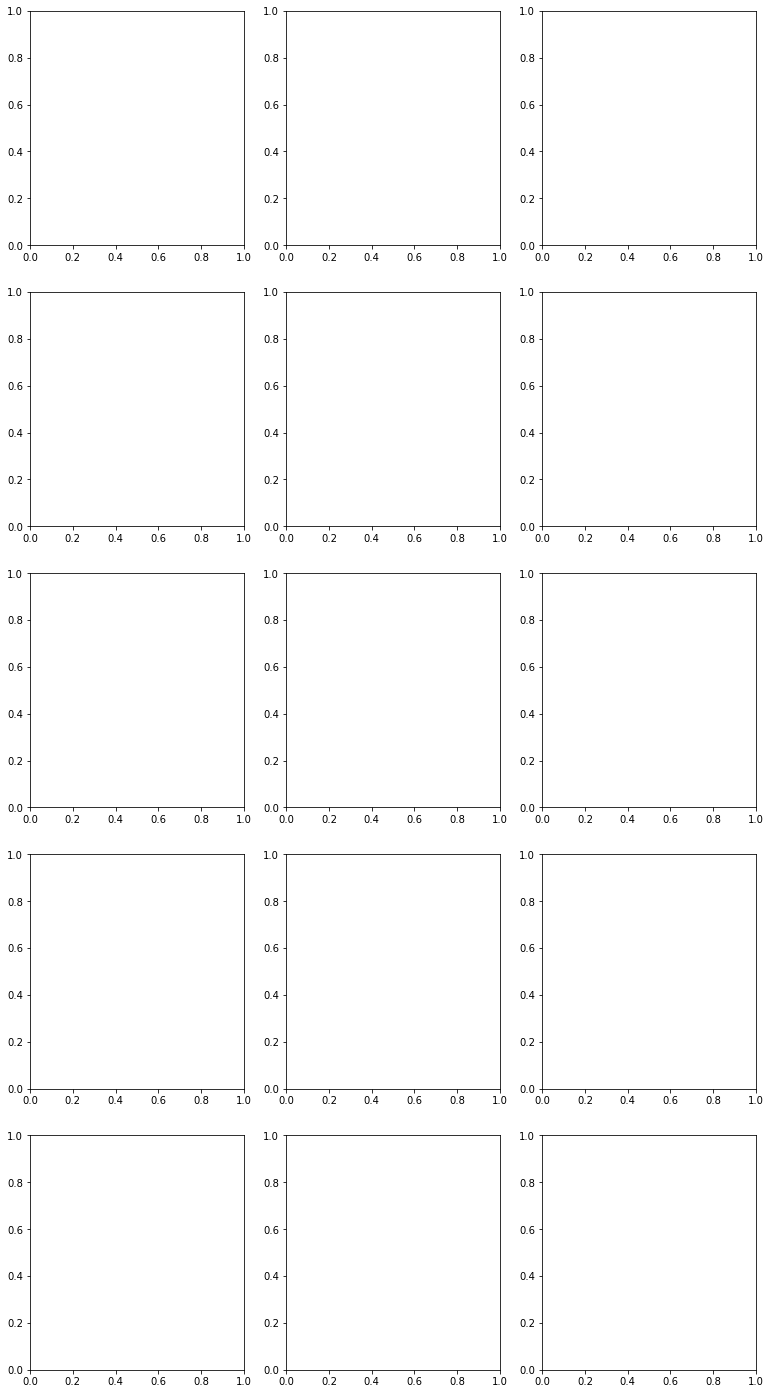

In [42]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for title in [
        "Historical Volume",
        "Absolute Historical Bias",
        "Historical Bias",
        "Absolute Change",
        "Relative Change",
    ]:
        print(title)
        fig, axarr = plt.subplots(nrows=len(ds_heatmap.lev), ncols=3, figsize=[13, 25])
        for li, l in enumerate(ds_heatmap.lev):
            for la, lat in enumerate([60, 40, 20]):

                ax = axarr[li, la]

                ds = ds_heatmap.copy()
                ds = ds.sel(lev=l)
                ds = ds.sel(lat_bin=slice(-lat, lat))
                ds = ds.sum("lat_bin")

                obs = ds_obs.copy()
                obs = obs.sel(lev=l)
                obs = obs.sel(lat_bin=slice(-lat, lat))
                obs = obs.sum("lat_bin")
                obs = obs.squeeze()

                #since any sum operation will always result in 0 for all nans, 
                # we need to mask empty members manually
                ds = ds.where(~ds_heatmap['empty_mask'])

    #             #average members (and later add sign_agreement)
    #             ds_mean = ds.mean("member_id")
    #             for va in ds_mean.data_vars:
    #                 ds_mean[va+'_sign_agreement'] = sign_agreement(ds[va], ds_mean[va], 'member_id', threshold=0.9)

                if title == "Historical Volume":
                    hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                    obs_vol = obs.volume
                    p = xr.concat([hist_vol, obs_vol], "model")
                    unit = "$m^3$"
                    percentile = 95
                elif title == "Historical Bias":
                    hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                    obs_vol = obs.volume
                    p = (hist_vol - obs_vol) / (obs_vol) * 100
                    unit = "% of observed"
                    percentile = 80
                elif title == "Absolute Historical Bias":
                    hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                    obs_vol = obs.volume.assign_coords(model="WOA_Bianchi")
                    p = hist_vol - obs_vol
                    unit = "$m^3$"
                    percentile = 99
                elif title == "Absolute Change":
                    p = slope(ds.volume.sel(time=trend_slice))
                    unit = "$m^3$/century"
                    percentile = 65
                elif title == "Relative Change":
                    hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                    p = (slope(ds.volume.sel(time=trend_slice)) / hist_vol) * 100
                    unit = "%/century"
                    percentile = 65
                else:
                    raise RuntimeError("NOPE")




                # I need to load here to get the clims
                p = p.load()

                # average over member and construct sign agreement
                p_all = p
                p = p.mean('member_id')
                sa = sign_agreement(p_all, p, 'member_id', threshold=0.9, count_nans=False)==0 #reverse because I want to hatch the ones that do not agree

                # somehow the damn pcolormesh does not like the data unless transposed a certain way
                p = p.transpose("model", "o2_bin")
                sa = sa.transpose("model", "o2_bin")

                clim = np.percentile(abs(p.fillna(0)).data.flat, percentile)
                heatmap(p, vmin=-clim, vmax=clim, cmap="RdBu_r", ax=ax, sign_agreements=[(sa, {'hatch':'///'})])
                ax.set_title(
                    f"{ds.lev_bounds[0].data}m-{ds.lev_bounds.data[1]}m  ({lat}S-{lat}N) \n"
                )
        fig.subplots_adjust(wspace=1.2, hspace=0.5)
        fig.suptitle(f"{title} [{unit}]", y=0.92, fontsize=20)
        plt.show()

## Consolidate the monster plots
- different stipling if sign changes across: lat range, depth range

Relative Change
REIMPORT THIS FROM XARRAYUTILS
REIMPORT THIS FROM XARRAYUTILS
REIMPORT THIS FROM XARRAYUTILS
REIMPORT THIS FROM XARRAYUTILS


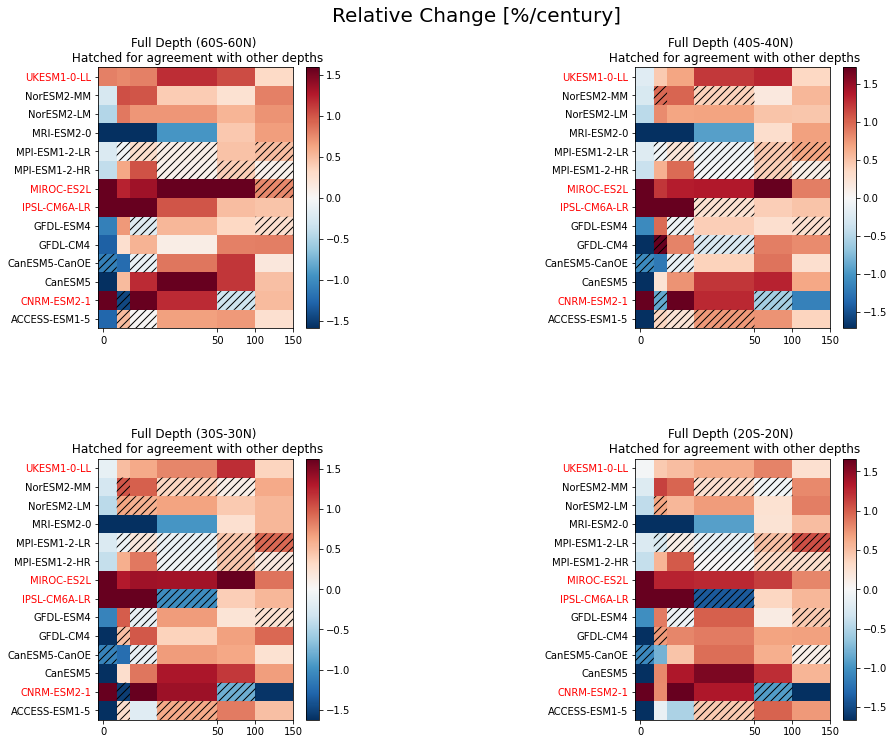

In [55]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for title in [
#         "Historical Volume",
#         "Absolute Historical Bias",
#         "Historical Bias",
#         "Absolute Change",
        "Relative Change",
    ]:
        print(title)
        fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[14, 12])
        for li, lat in enumerate([60, 40, 30, 20]):
            ax = axarr.flat[li]
            ds = ds_heatmap.copy()
            ds = ds.sel(lat_bin=slice(-lat, lat)).sum(['lat_bin']) # Lets for now just look at the tropics

            obs = ds_obs.copy()
            obs = obs.sel(lat_bin=slice(-lat, lat)).sum(['lat_bin']) # Lets for now just look at the tropics
            obs = obs.squeeze()

            #since any sum operation will always result in 0 for all nans, 
            # we need to mask empty members manually
            ds = ds.where(~ds_heatmap['empty_mask'])

            if title == "Historical Volume":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                obs_vol = obs.volume
                p = xr.concat([hist_vol, obs_vol], "model")
                unit = "$m^3$"
                percentile = 95
            elif title == "Historical Bias":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                obs_vol = obs.volume
                p = (hist_vol - obs_vol) / (obs_vol) * 100
                unit = "% of observed"
                percentile = 80
            elif title == "Absolute Historical Bias":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                obs_vol = obs.volume.assign_coords(model="WOA_Bianchi")
                p = hist_vol - obs_vol
                unit = "$m^3$"
                percentile = 99
            elif title == "Absolute Change":
                p = slope(ds.volume.sel(time=trend_slice))
                unit = "$m^3$/century"
                percentile = 65
            elif title == "Relative Change":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                p = (slope(ds.volume.sel(time=trend_slice)) / hist_vol) * 100
                unit = "%/century"
                percentile = 85
            else:
                raise RuntimeError("NOPE")




            # I need to load here to get the clims
            p = p.load()
            p = p.mean('member_id') # These are overall very similar so just average here

            # pick full depth but construct sign agreement across depth bins (these are not independent here)
            p_all = p
            p = p.isel(lev=-1)
            sa = sign_agreement(p_all, p, 'lev', threshold=0.9, count_nans=False)==0 #reverse because I want to hatch the ones that do not agree

            # somehow the damn pcolormesh does not like the data unless transposed a certain way
            p = p.transpose("model", "o2_bin")
            sa = sa.transpose("model", "o2_bin")

            clim = np.percentile(abs(p.fillna(0)).data.flat, percentile)
            heatmap(p, vmin=-clim, vmax=clim, y = 'model', x='o2_bin', cmap="RdBu_r", ax=ax, sign_agreements=[(sa, {'hatch':'///'})])
            ax.set_title(
                f"Full Depth ({lat}S-{lat}N) \n Hatched for agreement with other depths"
            )
            
        fig.subplots_adjust(wspace=1.2, hspace=0.5)
        fig.suptitle(f"{title} [{unit}]", y=0.95, fontsize=20)
        plt.show()

## Laure wants line plots

Relative Change


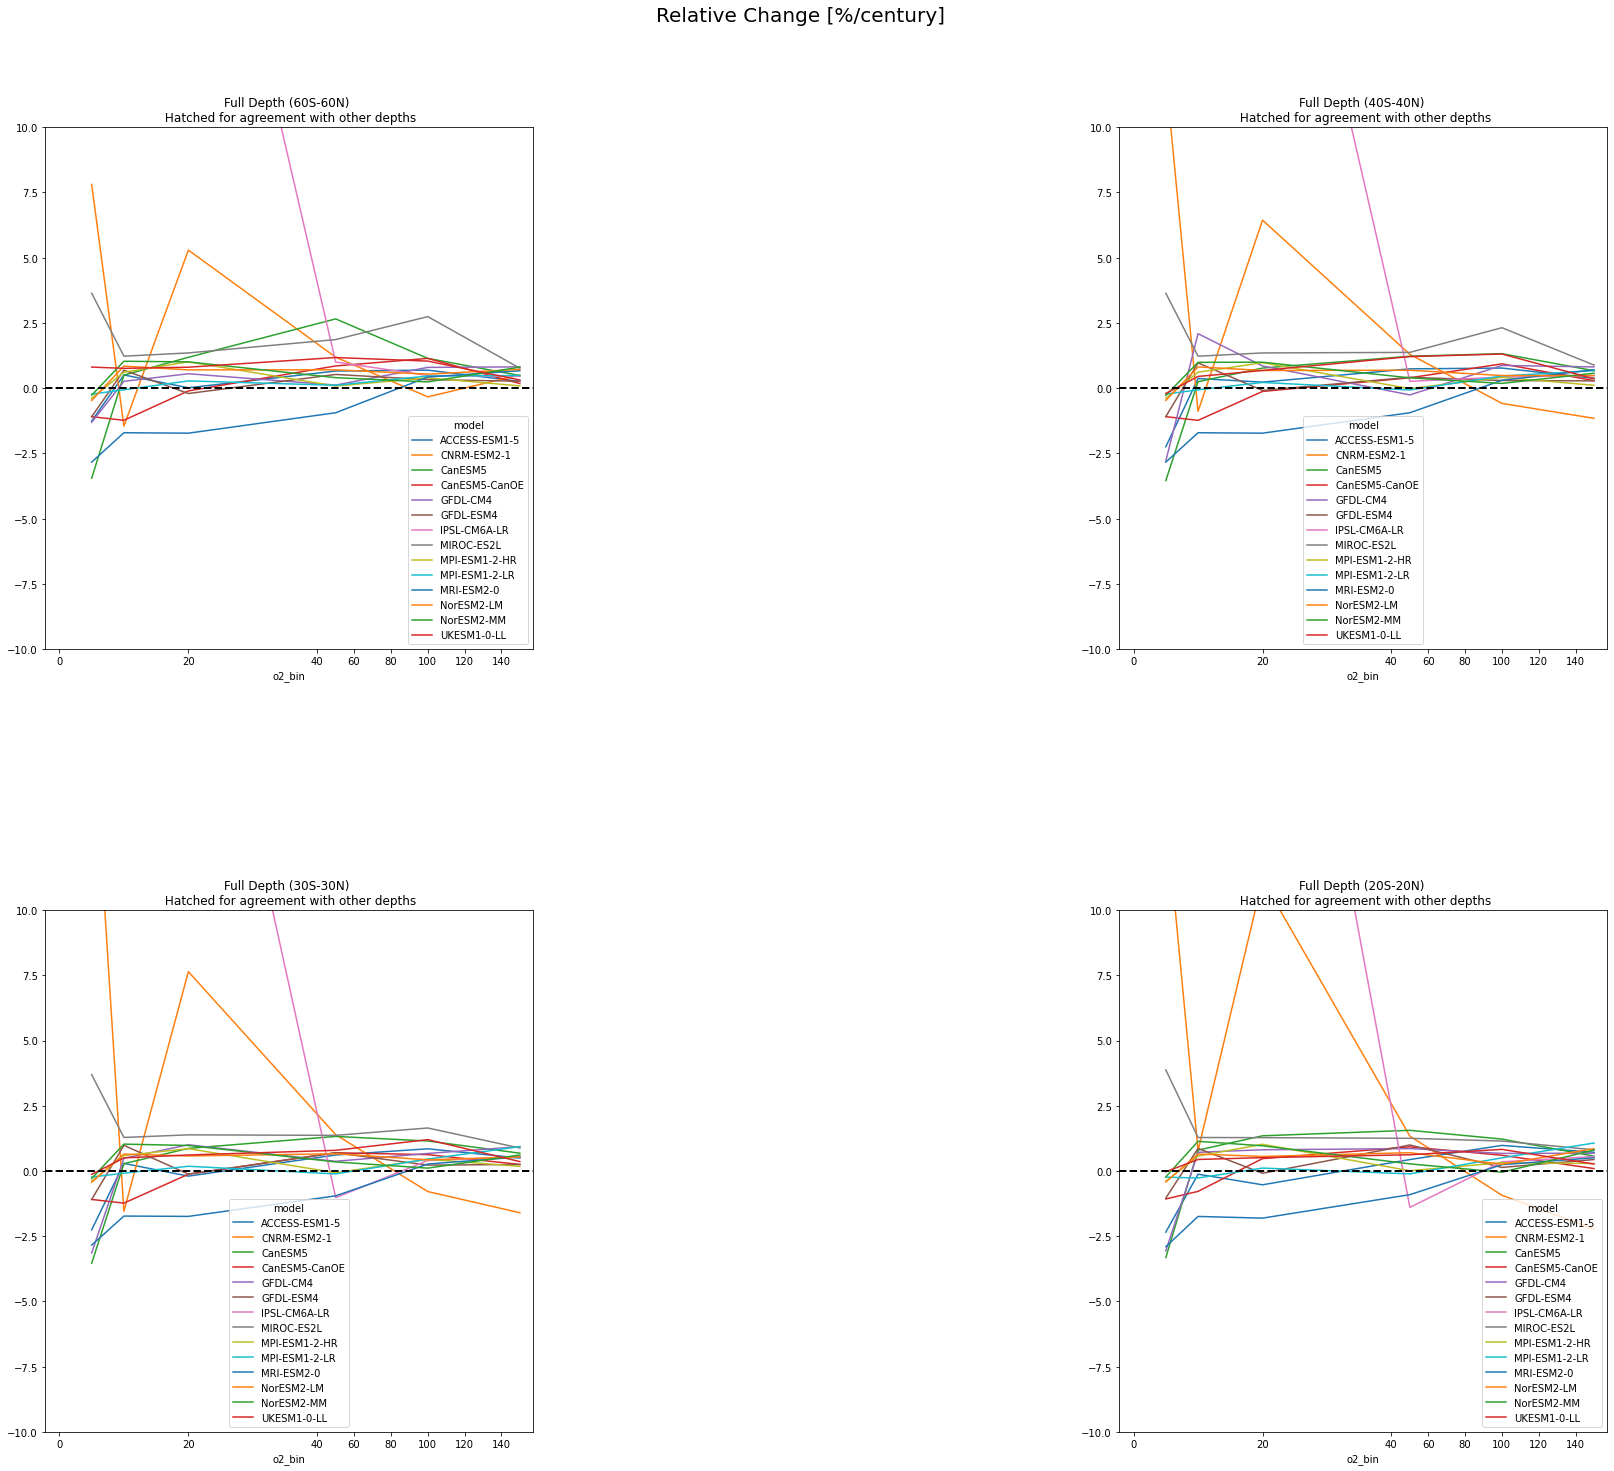

In [33]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for title in [
#         "Historical Volume",
#         "Absolute Historical Bias",
#         "Historical Bias",
#         "Absolute Change",
        "Relative Change",
    ]:
        print(title)
        fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=np.array([14, 12])*2)
        for li, lat in enumerate([60, 40, 30, 20]):
            ax = axarr.flat[li]
            ds = ds_heatmap.copy()
            ds = ds.sel(lat_bin=slice(-lat, lat)).sum(['lat_bin']) # Lets for now just look at the tropics

            obs = ds_obs.copy()
            obs = obs.sel(lat_bin=slice(-lat, lat)).sum(['lat_bin']) # Lets for now just look at the tropics
            obs = obs.squeeze()

            #since any sum operation will always result in 0 for all nans, 
            # we need to mask empty members manually
            ds = ds.where(~ds_heatmap['empty_mask'])

            if title == "Historical Volume":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                obs_vol = obs.volume
                p = xr.concat([hist_vol, obs_vol], "model")
                unit = "$m^3$"
                percentile = 95
            elif title == "Historical Bias":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                obs_vol = obs.volume
                p = (hist_vol - obs_vol) / (obs_vol) * 100
                unit = "% of observed"
                percentile = 80
            elif title == "Absolute Historical Bias":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                obs_vol = obs.volume.assign_coords(model="WOA_Bianchi")
                p = hist_vol - obs_vol
                unit = "$m^3$"
                percentile = 99
            elif title == "Absolute Change":
                p = slope(ds.volume.sel(time=trend_slice))
                unit = "$m^3$/century"
                percentile = 65
            elif title == "Relative Change":
                hist_vol = ds.volume.sel(time=hist_slice).mean("time")
                p = (slope(ds.volume.sel(time=trend_slice)) / hist_vol) * 100
                unit = "%/century"
                percentile = 85
            else:
                raise RuntimeError("NOPE")




            # I need to load here to get the clims
            p = p.load()
            p = p.mean('member_id') # These are overall very similar so just average here

            # pick full depth but construct sign agreement across depth bins (these are not independent here)
            p_all = p
            p = p.isel(lev=-1)
            
            p.plot(hue='model', ax=ax)# not the right color yet
            
            ax.set_title(
                f"Full Depth ({lat}S-{lat}N) \n Hatched for agreement with other depths"
            )
            ax.set_ylim(-10, 10)
            ax.axhline(0, lw=2, ls='--', color='k')
            scale_axis(ax)
        fig.subplots_adjust(wspace=1.2, hspace=0.5)
        fig.suptitle(f"{title} [{unit}]", y=0.95, fontsize=20)
        plt.show()

# Prototype in age

In [ ]:
# first test
for title in ['Historical Age', 'Absolute Age Change', 'Relative Age Change']:
# for title in ['Relative Age Change']:
    print(title)
    fig, axarr = plt.subplots(nrows = len(ds_heatmap.lev), ncols=3, figsize=[10, 25])
    for li, l in enumerate(ds_heatmap.lev):
        for la, lat in enumerate([60, 40, 20]):

            ax = axarr[li, la]
            
            ds = ds_heatmap.copy()
            
            ds = rebin_o2(ds)
            ds = ds.sel(lev=l)
            ds = ds.sel(lat_bin=slice(-lat, lat))
            ds = ds.sum('lat_bin')
            
            obs = ds_obs.copy()
            obs = rebin_o2(obs)
            obs = obs.sel(lev=l)
            obs = obs.sel(lat_bin=slice(-lat, lat))
            obs = obs.sum('lat_bin')
            
            age = ds.agessc/ds.volume
            
            if title == 'Historical Age':
                p =  age.sel(time=hist_slice).mean('time')
                unit = 'yrs'
                percentile = 100
            elif title == 'Absolute Age Change':
                p = slope(age)
                unit = 'yrs/century'
                percentile = 75
            elif title == 'Relative Age Change':
                p = slope(age) / age.sel(time=hist_slice).mean('time') * 100
                unit = '%/century'
                percentile = 90
            else:
                raise RuntimeError('NOPE')
                
            # do I want to mask out some things?
    #         mask = ds.volume_historical > 5e12  # base this on obs?
        #     p = p.where(mask)
            
            # somehow the damn pcolormesh does not like the data
            p = p.transpose('model', 'o2_bin')
            
            clim = np.percentile(abs(p.fillna(0)).data.flat, percentile)
            heatmap(p, vmin=-clim, vmax=clim, cmap='RdBu_r', ax=ax)
            ax.set_title(f'{ds.lev_bounds[0].data}m-{ds.lev_bounds.data[1]}m  ({lat}S-{lat}N) \n')

    fig.subplots_adjust(wspace=1.2, hspace=0.5)
    fig.suptitle(f'{title} [{unit}]', y=0.92, fontsize=20)
    plt.show()

## Timeseries at the lowest

In [24]:
sel_models = ['CNRM-ESM2-1', 'MIROC-ES2L', 'IPSL-CM6A-LR', 'UKESM1-0-LL']

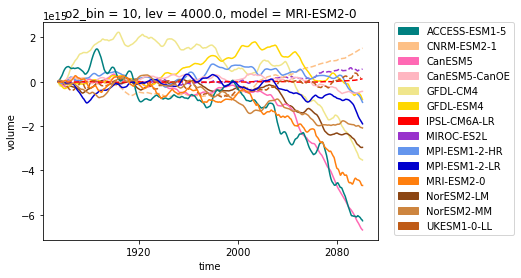

In [25]:
plt.figure()

for ds in datasets_final:
    if 'Bianchi' not in ds.source_id:
        ds_binned = depth_binning(ds).assign_coords(model=ds.source_id)
        ds_binned = ds_binned.sel(lev=4000)
        ds_binned = rebin_o2(ds_binned)
        ds_binned = ds_binned.isel(o2_bin=0).sum('lat_bin')
        
        p = ds_binned.volume
        p = p - p.isel(time=slice(0,50)).mean('time')
        p = p.rolling(time=12*5).mean()

        p.plot(color=o2_model_colors()[ds.source_id], ls='--' if ds.source_id in sel_models else '-')
    
model_color_legend()

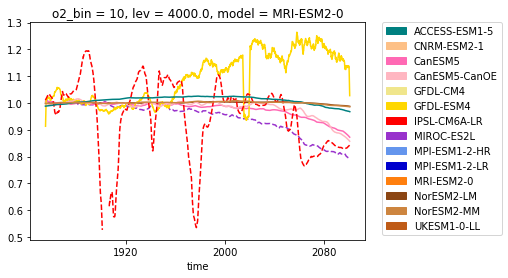

In [26]:
plt.figure()

sel_models = ['CNRM-ESM2-1', 'MIROC-ES2L', 'IPSL-CM6A-LR', 'UKESM1-0-LL']

for ds in datasets_final:
    if 'Bianchi' not in ds.source_id:
        ds_binned = depth_binning(ds).assign_coords(model=ds.source_id)
        ds_binned = ds_binned.sel(lev=4000)
        ds_binned = rebin_o2(ds_binned)
        ds_binned = ds_binned.isel(o2_bin=0).sum('lat_bin')
        age = ds_binned.agessc/ds_binned.volume
        
        p = age
        p = p/(p.sel(time=slice('1850', '1900')).mean('time'))
        p = p.rolling(time=12*5).mean()

        p.plot(color=o2_model_colors()[ds.source_id], ls='--' if ds.source_id in sel_models else '-')
    
model_color_legend()

## For the outer bins

these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins


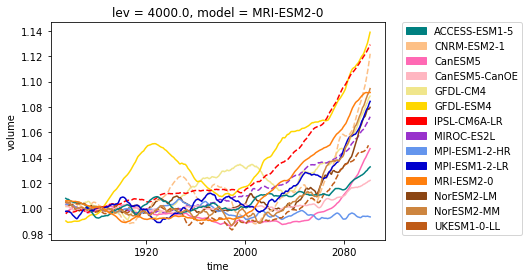

In [27]:
plt.figure()

for ds in datasets_final:
    if 'Bianchi' not in ds.source_id:

        ds_binned = depth_binning(ds).assign_coords(model=ds.source_id)
        ds_binned = ds_binned.sel(lev=4000)
        ds_binned = rebin_o2(ds_binned)

        print('these are several bins')
        ds_binned = ds_binned.isel(o2_bin=slice(-3,None)).sum(['o2_bin','lat_bin'])
    #     vol = vol - vol.isel(time=slice(0,50)).mean('time')
    
        p = ds_binned.volume
        p = p/(p.sel(time=slice('1850', '1900')).mean('time'))

        p = p.rolling(time=12*5).mean()

        p.plot(color=o2_model_colors()[ds.source_id], ls='--' if ds.source_id in sel_models else '-')
    
model_color_legend()

these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins
these are several bins


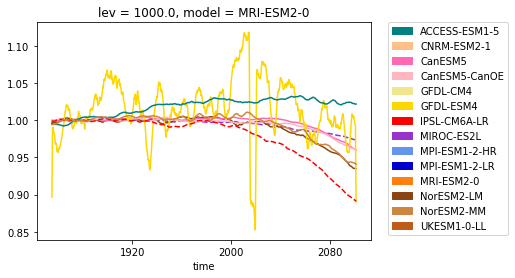

In [28]:
plt.figure()

for ds in datasets_final:
    if 'Bianchi' not in ds.source_id:

        ds_binned = depth_binning(ds).assign_coords(model=ds.source_id)
        ds_binned = ds_binned.sel(lev=1000)
        ds_binned = rebin_o2(ds_binned)

        print('these are several bins')
        ds_binned = ds_binned.isel(o2_bin=slice(-5,None)).sum(['o2_bin','lat_bin'])
        
        age = ds_binned.agessc / ds_binned.volume
    
        p = age
        p = p/(p.sel(time=slice('1850', '1900')).mean('time'))

        p = p.rolling(time=12*5).mean()

        p.plot(color=o2_model_colors()[ds.source_id], ls='--' if ds.source_id in sel_models else '-')
    
model_color_legend()

## Test age timeseries

GFDL-CM4
MIROC-ES2L
NorESM2-LM
CNRM-ESM2-1
CanESM5
GFDL-ESM4
MPI-ESM1-2-HR
CanESM5-CanOE
IPSL-CM6A-LR
UKESM1-0-LL
ACCESS-ESM1-5
MPI-ESM1-2-LR
NorESM2-MM
MRI-ESM2-0
GFDL-CM4
MIROC-ES2L
NorESM2-LM
CNRM-ESM2-1
CanESM5
GFDL-ESM4
MPI-ESM1-2-HR
CanESM5-CanOE
IPSL-CM6A-LR
UKESM1-0-LL
ACCESS-ESM1-5
MPI-ESM1-2-LR
NorESM2-MM
MRI-ESM2-0


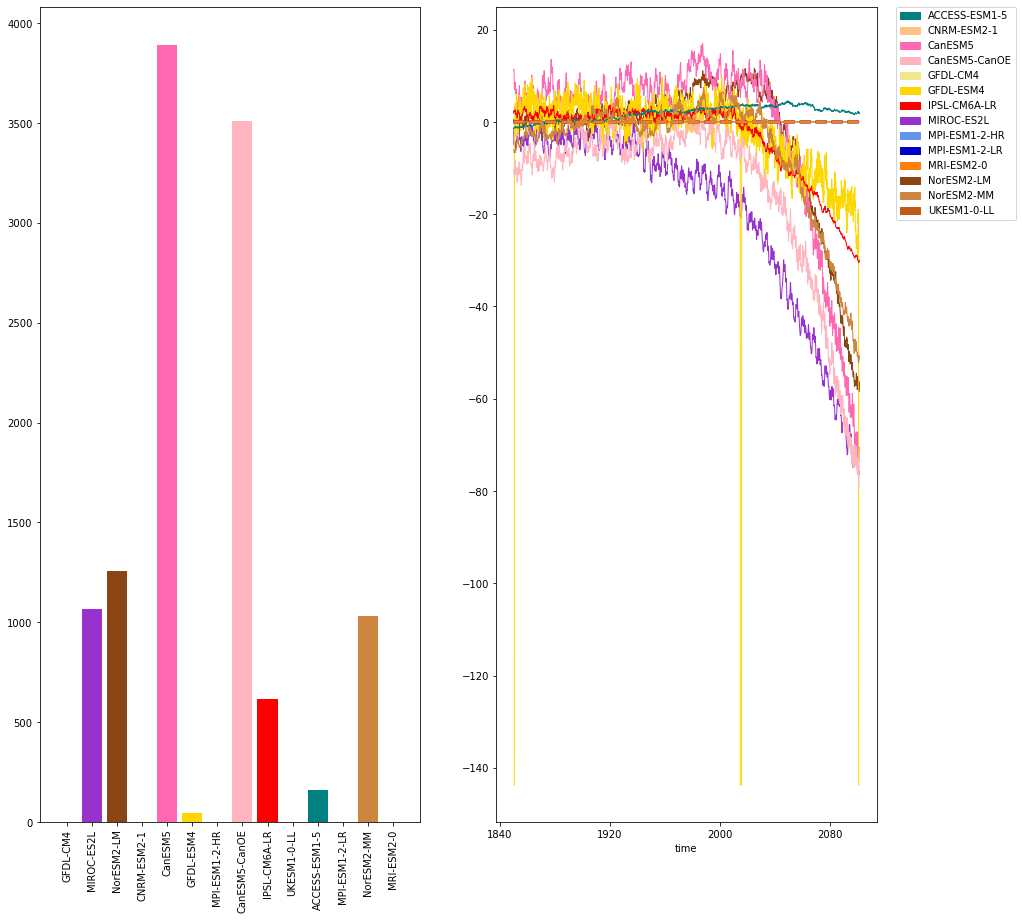

In [13]:
plt.figure(figsize=[15,15])
# plot global age anomaly
xlabels = []
xi = 0
plt.subplot(1,2,1)
for ds in datasets:
    print(ds.source_id)
    if 'agessc' in ds.data_vars:
        ds_deep = ds.sel(lev=slice(2000, None))
        sum_dims = [di for di in ds_deep.agessc.dims if di not in ['time']]
        age = ds_deep.agessc.sum(sum_dims)/ds_deep.volume.sum(sum_dims)
        
        age = age.isel(time=12*50)
        with ProgressBar():
            plt.bar(xi, age, color=o2_model_colors()[ds.source_id], alpha = 0.5 if ds.source_id in fail_age_models else 1.0)
            xlabels.append(ds.source_id)
            xi += 1

plt.xticks(ticks=np.arange(xi), labels=xlabels, rotation=90)


# plot global age anomaly
plt.subplot(1,2,2)
for ds in datasets:
    if 'agessc' in ds.data_vars:
        print(ds.source_id)
#         ds_deep = ds.sel(lev=slice(2000, None))
        ds_deep = ds.sel(lev=slice(200,1000))
        sum_dims = [di for di in ds_deep.agessc.dims if di not in ['time']]
        age = ds_deep.agessc.sum(sum_dims)/ds_deep.volume.sum(sum_dims)
        age = age - age.isel(time=12*50)
        with ProgressBar():
            age.plot(
                color=o2_model_colors()[ds.source_id],
                ls='--' if ds.source_id in fail_age_models else '-',
                lw=3 if ds.source_id in fail_age_models else 1,
            )
model_color_legend()

## Trouble with trends not agreeing...
I noticed that ESM4 now shows an increasing volume. This was not there before, and does not agree with a manual test. I suspect that rebin_o2 does something to the data?

Ok the issue was that the lowest bin was not included. That means there are a bunch near zero values in ESM4!

In [11]:
# # Check if any of ESM decreases

# ds_check = [ds for ds in datasets if ds.attrs.get('source_id')=='GFDL-ESM4'][0]
# timeseries = ds_check.sel(basin_mask_bin=['North Pacific Ocean',# lat_bin=slice(-20, 20),lev=slice(0,2000),
#        'South Pacific Ocean']).sum(['lat_bin', 'basin_mask_bin', 'lev'])

# timeseries_rebinned = rebin_o2(timeseries).isel(o2_bin=slice(0,1))
# timeseries = timeseries.isel(o2_bin=slice(0,2))
# timeseries = timeseries.sum('o2_bin')


# plt.figure()
# for ts in [timeseries, timeseries_rebinned]:
# #     ts = ts - ts.isel(time=0)
#     ts.volume.plot(hue='o2_bin')

## is there any volume <0 for any of the models?

- there are some incomplete members (ACCCES) - assert that `bin_count` remains the same over time. The volume actually drifts?
- The lowest bin should not have any values, but in many models there are some? Probably some numeric error in xhistogram? Express in % of total bins. !! Also investigate with xhistogram? 
    - are the bins right inclusive or left inclusive?
- I think this is a numerical issue after all, but I havent tested it in all models (see `negative_oxygen.ipynb`)